# Why expressions classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
codestral_classification_data_file_name = "./cme_codestral-latest_classification.csv"

The following dataset contains the answers of the model to the prompts to classify the category of the "Why" and "What" expression/

In [3]:
codestral_classification = pd.read_csv(codestral_classification_data_file_name)
codestral_classification.head()

,url,message,api_url,diff,why_category,why_category_expl,what_category,what_category_expl
0,https://github.com/junit-team/junit4/commit/31...,Relicense JUnit from CPL to EPL <enter> EPL i...,https://api.github.com/repos/junit-team/junit4...,"@@ -1,8 +1,8 @@\n JUnit\n \n-Common Public Lic...",Describe Objective,The commit message explains the objective of t...,Summarize Code Object Change,The commit message primarily describes the cha...
1,https://github.com/spring-projects/spring-boot...,Better diagnotics when ESCF subclass breaks wi...,https://api.github.com/repos/spring-projects/s...,"@@ -17,6 +17,7 @@\n package org.springframewor...",Describe Issue,The commit message describes the issue of fail...,Describe Implementation Principle,The commit message explains the technical prin...
2,https://github.com/spring-projects/spring-boot...,Update view of bean types when an override is ...,https://api.github.com/repos/spring-projects/s...,"@@ -76,7 +76,7 @@ final class BeanTypeRegistry...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the changes in t...
3,https://github.com/square/okhttp/commit/868ee8...,Drop our one remaining DSS cipher suite. <ent...,https://api.github.com/repos/square/okhttp/com...,"@@ -37,7 +37,7 @@\n */\n public final class C...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the code object ...
4,https://github.com/spring-projects/spring-boot...,Fix undertow access_log file name <enter> Und...,https://api.github.com/repos/spring-projects/s...,"@@ -384,7 +384,7 @@ private AccessLogHandler c...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the code object ...


In [4]:
n_codestral_classification = codestral_classification['what_category'].notna().sum()
print(f'The model categorize {n_codestral_classification} of {len(codestral_classification)} commit messages')

The model categorize 263 of 271 commit messages


In [5]:
codestral_classification['what_category'].value_counts()

what_category
Summarize Code Object Change         177
Describe Implementation Principle     73
Illustrate Function                   12
Missing What                           1
Name: count, dtype: int64

**Loading the manually labeled dataset (ground truth classification)**

In [6]:
manually_classification = pd.read_excel('../data/maintenance type and expression way.xlsx')

In [7]:
manually_classification.head()

,Commit ID,URL,Commit Message,Commit Type,Why Codes,Why Initial Category,Why Subcategory,Why Category,What Codes,What Initial Category,What Subcategory,What Category
0,S257,https://github.com/junit-team/junit4/commit/31...,Relicense JUnit from CPL to EPL <enter> EPL i...,Adaptive,EPL is the successor version of the CPL; CPL i...,bug/defect scenario,Describe error scenario,Describe issue,Relicense JUnit from CPL to EPL,Summarize the key changes,Object of change,Summarize code change
1,S258,https://github.com/spring-projects/spring-boot...,Better diagnotics when ESCF subclass breaks wi...,Corrective,This commit improves the diagnostics so that,Bug/Defect scenario,Describe error scenario,Describe issue,This commit improves the diagnostics; fail fa...,Summarize of function change,Illustrate function,Illustrate function
2,S259,https://github.com/spring-projects/spring-boot...,Update view of bean types when an override is ...,Corrective,This would lead to incorrect,Bug/Defect scenario,Describe error scenario,Describe issue,Update view of bean types when an override is ...,summarize code change and illustrate function,Contrast before and after& \nIllustrate function,Illustrate function& Summarize code change
3,S206,https://github.com/square/okhttp/commit/868ee8...,Drop our one remaining DSS cipher suite. <ent...,Perfective,"Tracking Chrome and Firefox, which have also d...",Change based on standards,Conventions and standards,Imply necessity,Drop our one remaining DSS cipher suite.,summarize code change,Object of change,Summarize code change
4,S173,https://github.com/spring-projects/spring-boot...,Fix undertow access_log file name <enter> Und...,Corrective,Undertow 1.3.2 changed the default access log...,Change because the environment change,Runtime or development environment change,Illustrate requirement,adapt the file name pattern to include the mi...,Describe the status of code object before and ...,Contrast before and after,Summarize code change


In [8]:
manually_classification['What Category'].value_counts()

What Category
Summarize code change                         174
Illustrate function                            52
Missing What                                   19
Illustrate function& Summarize code change     17
Describe implementation principle               9
Name: count, dtype: int64

In [9]:
manually_classification['What Category'] = manually_classification['What Category'].replace('Summarize code change', 'Summarize Code Object Change')
manually_classification['What Category'] = manually_classification['What Category'].replace('Illustrate function', 'Illustrate Function')
manually_classification['What Category'] = manually_classification['What Category'].replace('Describe implementation principle', 'Describe Implementation Principle')

In [10]:
considered_values = ['Summarize Code Object Change', 'Describe Implementation Principle', 'Illustrate Function', 'Missing What']
considered_values_idx = manually_classification[manually_classification['What Category'].isin(considered_values)].index
print(f'We are considering just {len(considered_values_idx)} of the {len(manually_classification)} commit messages')

We are considering just 254 of the 271 commit messages


In [11]:
codestral_classification.loc[considered_values_idx].shape

(254, 8)

In [12]:
codestral_classification_considered = codestral_classification.loc[considered_values_idx]
final_considered_values_idx = codestral_classification_considered[codestral_classification_considered['what_category'].notna()].index

In [13]:
human_classification_why = manually_classification.loc[final_considered_values_idx]['What Category']
human_classification_why

0           Summarize Code Object Change
1                    Illustrate Function
3           Summarize Code Object Change
4           Summarize Code Object Change
5           Summarize Code Object Change
                     ...                
266         Summarize Code Object Change
267         Summarize Code Object Change
268         Summarize Code Object Change
269    Describe Implementation Principle
270         Summarize Code Object Change
Name: What Category, Length: 247, dtype: object

In [14]:
codestral_predictions_why = codestral_classification.loc[final_considered_values_idx]['what_category']
codestral_predictions_why

0           Summarize Code Object Change
1      Describe Implementation Principle
3           Summarize Code Object Change
4           Summarize Code Object Change
5           Summarize Code Object Change
                     ...                
266         Summarize Code Object Change
267         Summarize Code Object Change
268    Describe Implementation Principle
269         Summarize Code Object Change
270         Summarize Code Object Change
Name: what_category, Length: 247, dtype: object

In [15]:
cohen_kappa_score(human_classification_why, codestral_predictions_why)

0.10447996468993359

In [16]:
cm = confusion_matrix(human_classification_why, codestral_predictions_why, labels=considered_values)

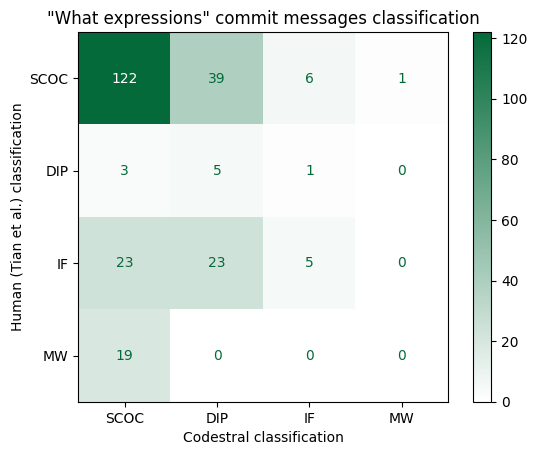

In [17]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['SCOC', 'DIP', 'IF', 'MW'])
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#046A3A"])
cm_display.plot(cmap=cmap)
plt.ylabel('Human (Tian et al.) classification')
plt.xlabel('Codestral classification')
plt.title('"What expressions" commit messages classification')
plt.show()

In [18]:
class_rep_dict = classification_report(human_classification_why,codestral_predictions_why, output_dict=True)
class_rep_dict['Average (weighted)'] = class_rep_dict.pop('weighted avg')
class_rep_dict.pop('accuracy')
class_rep_dict.pop('macro avg')

{'precision': 0.3054581136234993,
 'recall': 0.34494631185807656,
 'f1-score': 0.2546668287634509,
 'support': 247.0}

In [19]:
class_rep_df = pd.DataFrame(class_rep_dict).transpose()
class_rep_df

,precision,recall,f1-score,support
Describe Implementation Principle,0.074627,0.555556,0.131579,9.0
Illustrate Function,0.416667,0.098039,0.158730,51.0
Missing What,0.000000,0.000000,0.000000,19.0
Summarize Code Object Change,0.730539,0.726190,0.728358,168.0
Average (weighted),0.585636,0.534413,0.532970,247.0


In [20]:
class_rep_df.to_latex('what_expressions_eclassification_metrics.tex', float_format="%.2f")